# Explore Test Data

**Purpose: exploring data generated by sample code**


Data contains 4 attributes: `id, time, treatment (A), cov1 (X)`

$$A \sim Binomial(\text{invLogit}(\frac{X_{t-1} - \bar{x}}{10} - A_{t-1})$$
$$X \sim Normal(A_t + X_{t-1}, 1)$$

with initial conditions:

$$A_0 \sim Binomial(0.5)$$
$$X_0 \sim Normal(A_0, 1)$$

A shifted dataset is also generated with previous values of past covariates.

Attributes: 
- independent: `id, time, prev_treat, prev_cov1`
- dependent: `treatment` (classification), `prev_cov1` (regression)

In [5]:
import pandas as pd
import numpy as np
from pathlib import Path

from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
fIn = Path('./data/easiest_sim.csv')
fIn_shifted = Path('./data/easiest_sim_shifted.csv')
assert fIn.is_file() & fIn_shifted.is_file()

## Exploring sampled data

In [3]:
data = pd.read_csv(fIn)
data

,id,time,treatment,cov1
0,0,0.0,0,-0.802173
1,0,1.0,0,-1.251051
2,0,2.0,0,-2.356986
3,0,3.0,1,-3.011501
4,0,4.0,0,-4.028515
...,...,...,...,...
499995,9999,45.0,1,30.355866
499996,9999,46.0,0,31.582793
499997,9999,47.0,1,31.360519
499998,9999,48.0,1,33.516532


In [4]:
data_shifted = pd.read_csv(fIn_shifted)
data_shifted.set_index(['id', 'time'], inplace=True)
data_shifted

prev_treat  prev_cov1  treatment       cov1
id   time                                             
0    1.0          0.0  -0.802173          0  -1.251051
     2.0          0.0  -1.251051          0  -2.356986
     3.0          0.0  -2.356986          1  -3.011501
     4.0          1.0  -3.011501          0  -4.028515
     5.0          0.0  -4.028515          1  -2.391153
...               ...        ...        ...        ...
9999 45.0         0.0  28.434437          1  30.355866
     46.0         1.0  30.355866          0  31.582793
     47.0         0.0  31.582793          1  31.360519
     48.0         1.0  31.360519          1  33.516532
     49.0         1.0  33.516532          0  32.880983

[490000 rows x 4 columns]

### Treatment

<AxesSubplot:xlabel='time'>

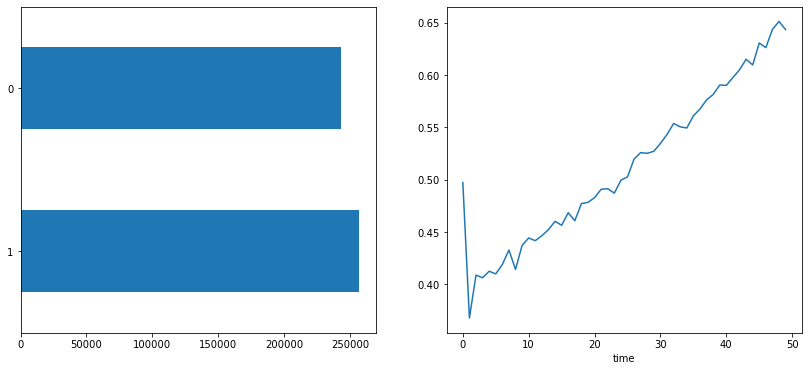

In [6]:
fig, axX = plt.subplots(1, 2, figsize=(14, 6))

# Bunched distribution of treatment
ax = axX.flatten()[0]
df_t = data['treatment'].value_counts()
df_t.plot.barh(ax=ax)

# Temporal distribution of treatment
ax = axX.flatten()[1]
df_t = data.groupby('time').treatment.mean()
df_t.plot(ax=ax)

### Covariate

<AxesSubplot:xlabel='treatment', ylabel='cov1'>

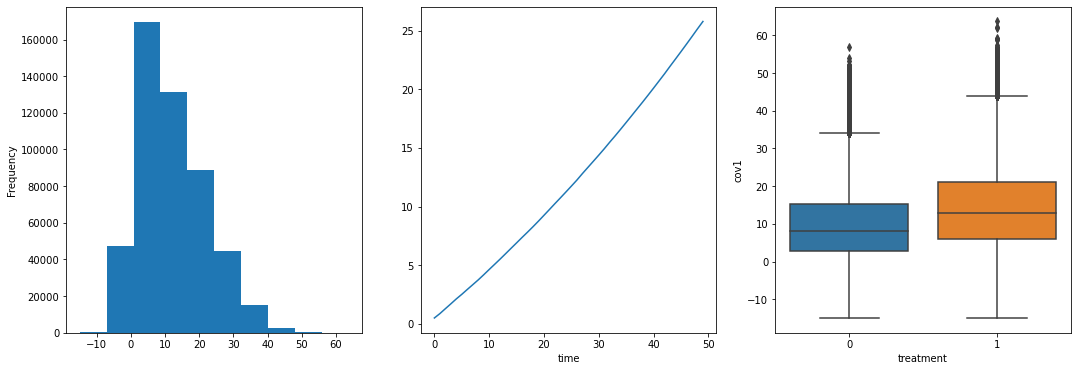

In [9]:
fig, axX = plt.subplots(1, 3, figsize=(18, 6))

# Bunched distribution of cov
ax = axX.flatten()[0]
data.cov1.plot.hist(ax=ax)

# Temporal distribution of cov
ax = axX.flatten()[1]
df_X = data.groupby('time').cov1.mean()
df_X.plot(ax=ax)

# Distribution of cov w.r.t treatment
ax = axX.flatten()[2]
sns.boxplot(x='treatment', y='cov1', data=data, ax=ax)

## Exploring a simple model

In [10]:
from statsmodels import api as sm
#model = sm.OLS

In [17]:
model = sm.OLS(data_shifted['cov1'], data_shifted[['prev_cov1', 'prev_treat']], hasconst=False)
results = model.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                   cov1   R-squared (uncentered):                   0.995
Model:                            OLS   Adj. R-squared (uncentered):              0.995
Method:                 Least Squares   F-statistic:                          4.592e+07
Date:                Mon, 02 May 2022   Prob (F-statistic):                        0.00
Time:                        17:47:16   Log-Likelihood:                     -7.6072e+05
No. Observations:              490000   AIC:                                  1.521e+06
Df Residuals:                  489998   BIC:                                  1.521e+06
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

Model coef and scores:  [ 1.01209139 -0.22268504] 0.9870257011547005


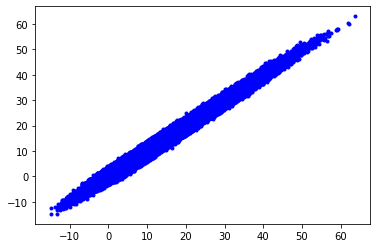

In [42]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(data_shifted[['prev_cov1', 'prev_treat']], data_shifted['cov1'])
print("Model coef and scores: ", 
      model.coef_,
      model.score(data_shifted[['prev_cov1', 'prev_treat']], data_shifted['cov1'])
     )

yhat = model.predict(data_shifted[['prev_cov1', 'prev_treat']])

fig, ax = plt.subplots()
ax.plot(data_shifted['cov1'], yhat, 'b.')

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, confusion_matrix, auc, roc_auc_score, precision_recall_curve, average_precision_score, PrecisionRecallDisplay, ConfusionMatrixDisplay

def plot_roc_auc(fpr, tpr, ax, 
                 xlabel='False Positive Rate', 
                 ylabel='True Positive Rate',
                 title='AUC ROC',
                 lw=2,
                 pl_color='darkorange',
                 plot_diag=True
                 ):
    roc_ = auc(fpr, tpr)

    ax.plot(fpr, tpr, color=pl_color, lw=lw,
        label="ROC curve (area = %0.2f)" % roc_,
    )

    if plot_diag:
        ax.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")

    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.legend(loc="lower right")
    return ax

Model coef and scores:  [[ 0.05137794 -0.9443211 ]] 0.6143714285714286
AUC ROC: 0.6598580578703025
AUC PRC: 0.661674490464172


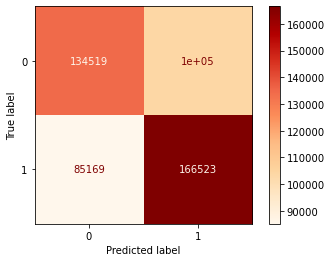

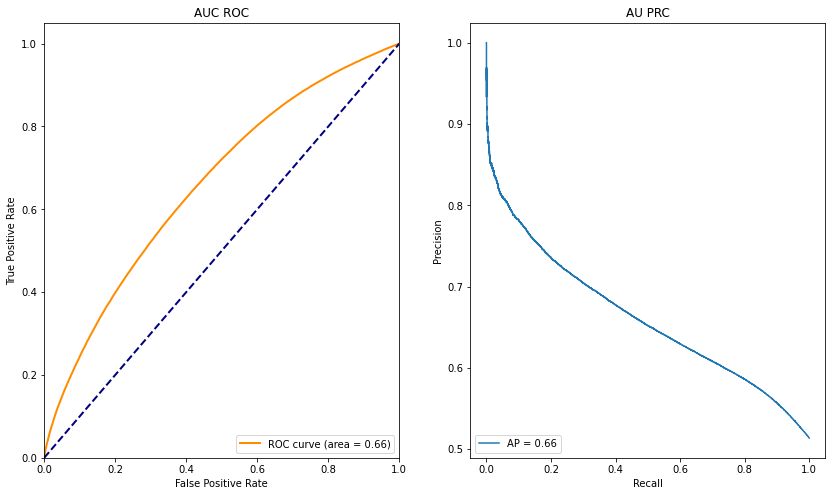

In [43]:
model = LogisticRegression()
model.fit(data_shifted[['prev_cov1', 'prev_treat']], data_shifted['treatment'])
print("Model coef and scores: ", 
      model.coef_,
      model.score(data_shifted[['prev_cov1', 'prev_treat']], data_shifted['treatment'])
     )

yhat = model.predict(data_shifted[['prev_cov1', 'prev_treat']])
y_proba = model.predict_proba(data_shifted[['prev_cov1', 'prev_treat']])[:, 1]

cmatrix = confusion_matrix(data_shifted['treatment'], yhat)
#print(cmatrix)
disp = ConfusionMatrixDisplay(confusion_matrix=cmatrix)
disp.plot(cmap='OrRd')

fpr, tpr, thresh = roc_curve(data_shifted['treatment'], y_proba)
roc_auc = roc_auc_score(data_shifted['treatment'], y_proba)
print('AUC ROC:', roc_auc)

pr, rc, thresh = precision_recall_curve(data_shifted['treatment'], y_proba)
auprc = average_precision_score(data_shifted['treatment'], y_proba)
print('AUC PRC:', auprc)

fig, axX = plt.subplots(1, 2 , figsize=(14, 8))

ax = axX.flatten()[0]
plot_roc_auc(fpr, tpr, ax=ax, plot_diag=True)

ax = axX.flatten()[1]
disp = PrecisionRecallDisplay(pr, rc, average_precision=auprc)
disp.plot(ax=ax)
_ = ax.set_title('AU PRC')